# Algorithm Walkthrough with Dummy Example

In [107]:
# Import packages.
import sys
import numpy as np
import time
import gzip
import shutil
import re
import support_code as supp

try:
    logaddexp = np.logaddexp
except AttributeError:
    def logaddexp(logx, logy):
        if logy - logx > 100:
            return logy
        elif logx - logy > 100:
            return logx
        minxy = min(logx, logy)
        return minxy + np.log(np.exp(logx - minxy) + np.exp(logy - minxy))

# Print versions of our libraries.
print('numpy', np.__version__)
print('gzip', np.__version__)
print('shutil', np.__version__)
print('re', np.__version__)

numpy 1.22.3
gzip 1.22.3
shutil 1.22.3
re 1.22.3


### Introduction and Assumptions

This Hidden Markov Model will give the probability of being in state $S_i$ at locus $T$, given:
- the HMM $\lambda$, representing Pruf'ers assumed parameters
- the observed sequence $O$, comprised of the state space $i$ $\in$ {C,N}. It is a string of labels representing 500bp locus "bins" in a genome that are Consistent (C) or Not Consistent (N) with a history of introgression.
- the locus position $t$ in the sequence $1 \le t < T$, where $T$ is the length of the sequence

To understand how the HMM functions, consider the observed sequence `NNCCN` ($T = 5$) with the underlying true states `SSIIS` and the default HMM $\lambda$ outlined in Prufer et al. (2014), whose assumptions are as follows:
- **Transition probability between ancestries ($s$) is 0.0005 Morgans.** The authors expected very small segments of shared haplotypes due to being broken up by millennia of recombiantion. Assuming a constant recombination rate across chromosomes, the expected length of 2,000-generation-old admixture would be 1/2000 or 0.0005 Morgans.
- **Probability of archaic ancestry at any locus ($p$) is 0.01.** This number corresponds to a Neanderthal admixture proportion of 1%, which is conservatively at the low end of the range of what has previously been reported.
- **Probability of archaic ancestry in a "C"-labeled locus and Probability of modern human ancestry in an "N"-labeled locus ($u$) is 0.99.** This allows for some probability of a test haplotype not being introgressed even if locally it is a clade with an archaic haplotype due to incomplete lineage sorting.

`Ob` represents the full observed sequence `NNCCN`, which must be binary-encoded to facilitate B-matrix referencing, which means is is turned into the string `00110`.

In [108]:
# Setting up parameters
s = .0005 # Ancestral switch rate
p = 0.01 # Prior probability for archaic ancestry at any locus (initial distribution)
u = 0.99 # Prior probability of archaic ancestry conditional on all SNPs in the window being of state "C"
threshold = .9 # Probability cutoff for HMM's "guess" at a true state (must be above 90%)
N = 2 # State space (State 0 = 'S' (Species/sapiens), State 1 = 'I' (Introgressed/neandertalensis))
M = 2 # Observation space (Observation 0 = 'N' (not consistent), Observation 1 = 'C' (consistent))
# Setting up other parameters
normalized = False # Does not normalize results based on relative probability
optimization_limit = 0 # Primary Baum-Welch adjustment parameter, to make sure it doesn't overfit
observed_sequence = "NNCCN"
# index letter observations for future use
observations = ['N', 'C']
# Ob is the same as the observation sequence, but with 'N'-> 0 and 'C'-> 1 for quick referencing.
Ob = [observations.index(label) for label in observed_sequence]
# sequence length
T = len(Ob)

---
### Visualization of Prufer's HMM
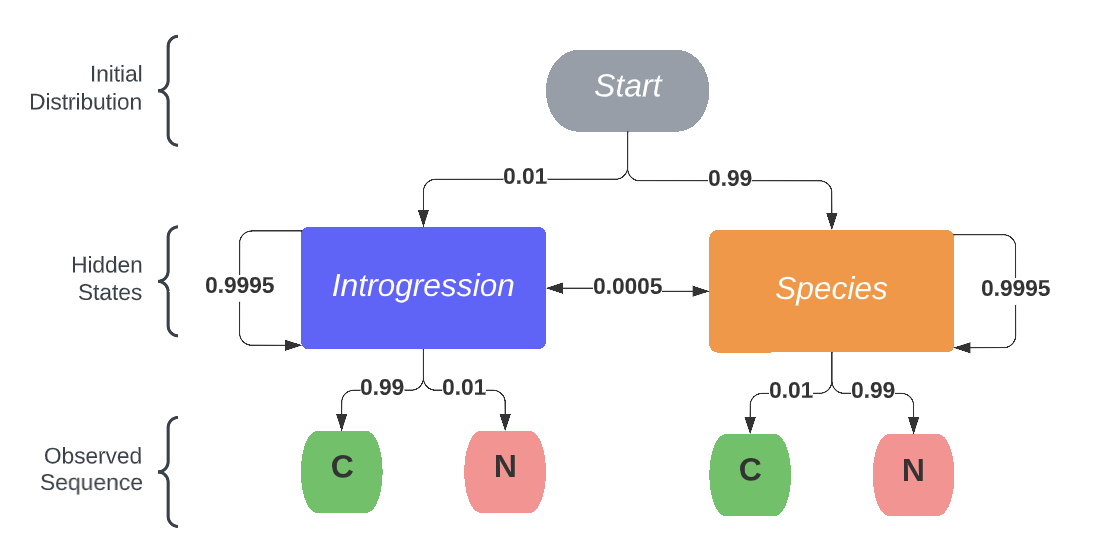

---
### Mathematical Representation of $\lambda$

| A | Species | Introgressed |
| :--- | --- | --- |
| Species | 99.95% | 0.05% |
| Introgressed | 0.05% | 99.95% |

| B | N | C |
| :--- | --- | --- |
| Species | 99% | 1% |
| Introgressed | 1% | 99% |

| pi | Species | Introgressed |
| :--- | --- | --- |
| Start | 99% | 1% |

In [123]:
# All calculations are done in log-space to prevent point-underflows

# Transition Probabilities (2x2)
A = np.array(((1 - s, s), (s, 1 - s)))
lp_A = np.log(A)

# Emission Probabilities (2x2)
B = np.array(((u, 1 - u), (1 - u, u)))
lp_B = np.log(B)

# Initial State Distribution (2x1)
pi = np.array((1 - p, p))
lp_pi = np.log(pi)

print(A)
print('---')
print(B)
print('---')
print(pi)

[[9.995e-01 5.000e-04]
 [5.000e-04 9.995e-01]]
---
[[0.99 0.01]
 [0.01 0.99]]
---
[0.99 0.01]


---
### The Forward Algorithm and the $\alpha$ Matrix

To learn about the purpose, input, and output of `calc_alpha()`, as well the commented code, refer to `1_rep_outline_workflow.ipynb`.

To find a line-by-line breakdown of the code, refer to the overleaf document `HMM-Ancestral-Inference`.

#### $\alpha$ Matrix Template for `NNCCN`

| Prefix Length | Prefix | State 0 (ends in `Species`) | State 1 (ends in `Introgressed`) |
| --- | --- | --- | --- |
| t=0 | No characters | P(first state is `S`) | P(first state is `I`) |
| t=1 |`N` | P(ends at state `S` \| Prefix `N`) | P(ends at state `I` \| Prefix `N`) |
| t=2 |`NN` | P(ends at state `S` \| Prefix `NN`) | P(ends at state `I` \| Prefix `NN`) |
| t=3 |`NNC` | P(ends at state `S` \| Prefix `NNC`) | P(ends at state `I` \| Prefix `NNC`) |
| t=4 |`NNCC` | P(ends at state `S` \| Prefix `NNCC`) | P(ends at state `I` \| Prefix `NNCC`) |
| T=4 |`NNCCN` | P(ends at state `S` \| Prefix `NNCCN`) | P(ends at state `I` \| Prefix `NNCCN`) |

In [124]:
def calc_alpha(A, B, pi, Ob, N, T):
    alpha = np.zeros((T + 1, N))
    alpha[0, :] = pi
    for t in range(1, T + 1):
        k = Ob[t - 1]
        for j in range(N):
            lprob = np.NINF
            for i in range(N):
                lp = alpha[t - 1][i] + A[i][j] + B[i][k]
                lprob = logaddexp(lprob, lp)
            alpha[t][j] = lprob
    return alpha

In [125]:
# showing 3 nearest decimal places
np.set_printoptions(precision=3)
alpha = np.exp(calc_alpha(lp_A, lp_B, lp_pi, Ob, N, T))
alpha

array([[9.900e-01, 1.000e-02],
       [9.796e-01, 5.900e-04],
       [9.693e-01, 4.908e-04],
       [9.689e-03, 4.905e-04],
       [9.708e-05, 4.854e-04],
       [9.606e-05, 4.900e-06]])

Note that combining the last two cells in the $\alpha$ matrix gives the total likelihood that the observed sequence was generated by the HMM $\lambda$.

---
### The Forward Algorithm and the $\beta$ Matrix

To learn about the purpose, input, and output of `calc_beta()`, as well the commented code, refer to `1_rep_outline_workflow.ipynb`.

To find a line-by-line breakdown of the code, refer to the overleaf document `HMM-Ancestral-Inference`.

#### $\beta$ Matrix Template  for `NNCCN`

| Suffix Length | Suffix | State 0 (came from `Species`) | State 1 (came from `Introgressed`) |
| --- | --- | --- | --- |
| t=0 |`NNCCN`| P(Sequence `NNCCN` \| from `S`) | P(Sequence `NNCCN` \| from `I`) |
| t=1 |`NCCN`| P(Sequence `NCCN` \| from `S`) | P(Sequence `NCCN` \| from `I`) |
| t=2 |`CCN`| P(Sequence `CCN` \| from `S`) | P(Sequence `CCN` \| from `I`) |
| t=3 |`CN`| P(Sequence `CN` \| from `S`) | P(Sequence `CN` \| from `I`) |
| t=4 |`N` | P(Sequence `N` \| from `S`) | P(Sequence `N` \| from `I`) |
| T=5 |No Characters | 1 | 1 |

In [126]:
def calc_beta(A, B, Ob, N, T):
    beta = np.zeros((T + 1, N))
    for t in range(T - 1, -1, -1):
        k = Ob[t]
        for j in range(N):
            lprob = np.NINF
            for i in range(N):
                lp = beta[t + 1][i] + A[j][i] + B[j][k]
                lprob = logaddexp(lprob, lp)
            beta[t][j] = lprob
    return beta

In [127]:
beta = np.exp(calc_beta(lp_A, lp_B, Ob, N, T))
beta

array([[1.020e-04, 1.028e-06],
       [1.030e-04, 1.028e-04],
       [9.895e-05, 1.028e-02],
       [9.895e-03, 1.039e-02],
       [9.900e-01, 1.000e-02],
       [1.000e+00, 1.000e+00]])

---
### The Forward Algorithm and the $\xi$ Matrix

To learn about the purpose, input, and output of `calc_xi()`, as well the commented code, refer to `1_rep_outline_workflow.ipynb`.

To find a line-by-line breakdown of the code, refer to the overleaf document `HMM-Ancestral-Inference`.

#### $\xi$ Matrix Template for `NNCCN`

$\xi$ (Front Side):

| Transition Start | Observed Transition | State `S` went to State `S` | State `S` went to State `I` |
| :--- | :--- | :--- | :--- |
| t=0 | `N` $\Rightarrow$ `N` | P(`S` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `N`) | P(`S` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `N`) |
| t=1 | `N` $\Rightarrow$ `C` | P(`S` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `C`) | P(`S` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `C`) |
| t=2 | `C` $\Rightarrow$ `C` | P(`S` $\Rightarrow$ `S` \| `C`$\Rightarrow$ `C`) | P(`S` $\Rightarrow$ `I` \| `C`$\Rightarrow$ `C`) |
| t=3 | `C` $\Rightarrow$ `N` | P(`S` $\Rightarrow$ `S` \| `C`$\Rightarrow$ `N`) | P(`S` $\Rightarrow$ `I` \| `C`$\Rightarrow$ `N`) |
| t=4 | `N` $\Rightarrow$ `end` | P(`S` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `end`) | P(`S` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `end`) 

$\xi$ (Back Side):

| Transition Start | Observed Transition | State `I` went to State `S` | State `I` went to State `I` |
| :--- | :--- | :--- | :--- |
| t=0 | `N` $\Rightarrow$ `N` | P(`I` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `N`) | P(`I` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `N`) |
| t=1 | `N` $\Rightarrow$ `C` | P(`I` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `C`) | P(`I` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `C`) |
| t=2 | `C` $\Rightarrow$ `C` | P(`I` $\Rightarrow$ `S` \| `C`$\Rightarrow$ `C`) | P(`I` $\Rightarrow$ `I` \| `C`$\Rightarrow$ `C`) |
| t=3 | `C` $\Rightarrow$ `N` | P(`I` $\Rightarrow$ `S` \| `C`$\Rightarrow$ `N`) | P(`I` $\Rightarrow$ `I` \| `C`$\Rightarrow$ `N`) |
| t=4 | `N` $\Rightarrow$ `end` | P(`I` $\Rightarrow$ `S` \| `N`$\Rightarrow$ `end`) | P(`I` $\Rightarrow$ `I` \| `N`$\Rightarrow$ `end`) 

In [128]:
def calc_xi(A, B, Ob, N, T, alpha, beta):
    xi = np.zeros((T, N, N))
    for t in range(T):
        k = Ob[t]
        lp_traverse = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                lp = (
                        alpha[t][i]
                        + A[i][j]
                        + B[i][k]
                        + beta[t + 1][j]
                )
                lp_traverse[i][j] = lp
        xi[t, :, :] = lp_traverse - supp.logsum(lp_traverse)
    return xi

In [129]:
xi = np.exp(calc_xi(lp_A, lp_B, Ob, N, T, alpha, beta))
xi[0]

array([[9.957e-01, 4.981e-04],
       [1.888e-06, 3.775e-03]])